Investigate the performance of acoustic individual recognition as the pool of individuals increases in size

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import HDBSCAN
import sys
from tqdm.autonotebook import tqdm

from matplotlib import pyplot as plt
def figsize(w,h):
    plt.rcParams['figure.figsize']=[w,h]
figsize(15,5) #for big visuals
%config InlineBackend.figure_format = 'retina'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# local tooling
sys.path.append('../../src/')

def identity(x):
    return x


# palette with many colors, starts w light grey
palette_w_grey = [(0.9, 0.9, 0.9)] + sns.color_palette("deep") + sns.color_palette("Dark2")
palette = sns.color_palette("deep") + sns.color_palette("Dark2")

/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_60718/3389864754.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Download the public 4-year passive acoustic monitoring dataset, and put the path here
dataset_path = Path("../../../pam_dataset_v4/")

In [3]:
import scipy
from sklearn.metrics import accuracy_score


def mode(x):
    vals, counts = np.unique(x, return_counts=True)
    return vals[np.argmax(counts)]


# Cluster Purity
def cluster_purity(true_labels, predicted_labels):
    cluster_labels = np.unique(predicted_labels)
    majority_labels = []
    true_labels_reordered = []
    for label in cluster_labels:
        indices = np.where(predicted_labels == label)
        # Select the most common true label in the predicted cluster
        majority_label = mode(np.array(true_labels)[indices])
        majority_labels.extend([majority_label] * len(indices[0]))
        true_labels_reordered.extend(true_labels[indices])
    return accuracy_score(true_labels_reordered, majority_labels)

In [4]:
min_samples = 30

dets = pd.read_csv(dataset_path / "per_point_clusters.csv")[
    ["point_code", "site", "date", "time", "cluster_30", "clustered_30"]
]
features = np.load(dataset_path / "oven_clips_aiid_embeddings_tsne-3d.npy")
dets["features"] = list(features)
# drop sites with fewer than 50 detections
dets = dets.groupby("point_code").filter(lambda x: len(x) >= min_samples)

In [5]:
# load pre-created results, or run the analysis to generate them:
use_precomputed_results = True
results_path = Path("../../results/clustering_with_n_points.csv")
if results_path.exists() and use_precomputed_results:
    results = pd.read_csv(results_path)
else:
    all_points = dets.point_code.unique()
    nreps = 20
    records = []
    for allow_single in (False, True):
        hdb = HDBSCAN(min_samples=min_samples, allow_single_cluster=allow_single)

        for n_points in (1, 2, 4, 8, 16, 32, 64, dets.point_code.nunique()):

            # start with 50 random points of all choices, and select n_points-1 others to compare with it
            for point_code in tqdm(np.random.choice(all_points, nreps, replace=False)):

                # select n_points sites, including this one (point_code)
                points = list(
                    np.random.choice(all_points, n_points - 1, replace=False)
                ) + [point_code]

                # all detections from any of these points:
                points_dets = dets[dets.point_code.apply(lambda x: x in points)].copy()
                # limit to 200 * n_point samples, to avoid memory issues
                max_dets = n_points * 200
                if len(points_dets) > max_dets:
                    points_dets = points_dets.sample(max_dets)

                # cluster with hdbscan
                hdb.fit(np.vstack(points_dets["features"].values))
                points_dets["label"] = hdb.labels_

                # which clusters contain detections from multiple points?
                # first, drop samples not assigned to a cluster
                assigned = points_dets[points_dets.label > -1]
                # calculate cluster purity/contamination with multiple points

                records.append(
                    {
                        "n_points": n_points,
                        "n_clusters": len(set(np.unique(hdb.labels_)) - set([-1])),
                        "clustered_fraction": len(assigned) / len(points_dets),
                        "allow_single": allow_single,
                        "per_point_clusters": len(
                            [
                                c
                                for c in points_dets.cluster_30.unique()
                                if not "-1" in c
                            ]
                        ),
                        "purity": cluster_purity(
                            assigned["point_code"].values, assigned["label"].values
                        ),
                    }
                )
    results = pd.DataFrame(records)
    results.to_csv(results_path, index=False)

In [7]:
summary = results.groupby(["n_points", "allow_single"]).mean()
summary.round(2).to_csv("../../results/clustering_with_n_points_summary.csv")
summary.round(2)

n_clusters  clustered_fraction  per_point_clusters  \
n_points allow_single                                                       
1        False               2.40                0.84                4.65   
         True                2.25                0.83                4.35   
2        False               3.50                0.87               10.20   
         True                3.30                0.88                9.40   
4        False               6.70                0.88               18.00   
         True                7.40                0.88               17.85   
8        False              13.60                0.86               36.15   
         True               13.40                0.87               37.30   
16       False              30.55                0.83               71.00   
         True               29.80                0.84               72.55   
32       False              62.25                0.79              145.95   
         True               43.35                0.86              147.65   
64       False             127.15                0.77              296.50   
         True               13.40                0.97              285.50   
119      False             236.50                0.76              538.70   
         True                1.00                0.98              538.35   

                       purity  
n_points allow_single          
1        False           1.00  
         True            1.00  
2        False           0.96  
         True            0.96  
4        False           0.96  
         True            0.96  
8        False           0.95  
         True            0.90  
16       False           0.96  
         True            0.92  
32       False           0.97  
         True            0.70  
64       False           0.97  
         True            0.15  
119      False           0.96  
         True            0.03

Plot cluster counts, purity, and recall vs n points clustered; and counts vs per-point cluster counts

In [53]:
palette = list(sns.palettes.color_palette("Dark2"))
palette = palette[:2][::-1]
palette

[(0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.10588235294117647, 0.6196078431372549, 0.4666666666666667)]

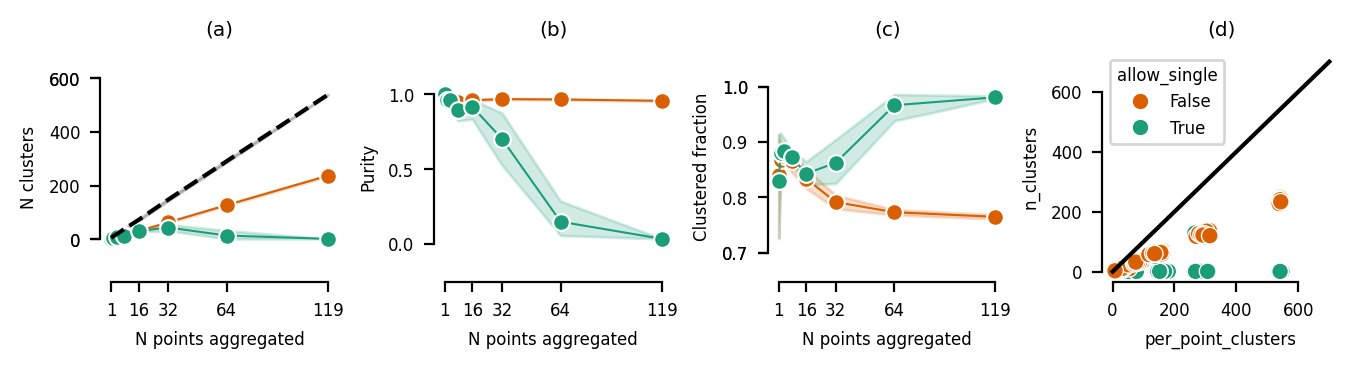

In [71]:
import seaborn as sns

sns.set_palette(palette)
figsize(8, 1.5)
plt.rcParams["font.size"] = 6
fig, axs = plt.subplots(1, 4)

# number of clusters
sns.lineplot(
    results.sort_values(by="allow_single", ascending=False),
    x="n_points",
    y="n_clusters",
    hue="allow_single",
    ax=axs[0],
    marker="o",
    size=5,
)
sns.lineplot(
    results.sort_values(by="allow_single", ascending=False),
    x="n_points",
    y="per_point_clusters",
    color="black",
    linestyle="--",
    ax=axs[0],
)
# axs[0].set_title('Clusters per point')

# cluster purity
sns.lineplot(
    results, x="n_points", y="purity", hue="allow_single", ax=axs[1], marker="o", size=5
)

# fraction of clips clustered
sns.lineplot(
    results.sort_values(by="allow_single", ascending=False),
    x="n_points",
    y="clustered_fraction",
    hue="allow_single",
    ax=axs[2],
    marker="o",
    size=5,
)


sns.scatterplot(
    data=results.sort_values(by="allow_single", ascending=False),
    x="per_point_clusters",
    y="n_clusters",
    hue="allow_single",
    ax=axs[3],
)
axs[3].plot([0, 700], [0, 700], c="black")

axs[0].legend_.remove()
axs[1].legend_.remove()
axs[2].legend_.remove()

axs[0].set_yticks([0, 0, 200, 400, 600, 600])
axs[2].set_yticks([0.7, 0.7, 0.8, 0.9, 1.0, 1.0])

for ax in axs:
    # despine
    sns.despine(ax=ax)

    # get min max vlaue of tick marks:
    ymin, ymax = ax.get_yticks()[1], ax.get_yticks()[-2]
    ax.spines["left"].set_bounds(ymin, ymax)


for ax in axs[0:3]:
    ax.set_xticks([1, 16, 32, 64, 119])
    # ax.set_xticklabels([1,16,32,64,119])
    ax.set_xlabel("N points aggregated")
    ax.set_ylabel(ax.get_ylabel().replace("_", " ").capitalize())

    # increase spacing between data and x axis. Move x axis down
    ax.margins(y=0.3, x=0.05)
    ax.spines["bottom"].set_bounds(1, 119)

axs[3].spines["bottom"].set_bounds(0, 600)

axs[0].set_title("(a)")
axs[1].set_title("(b)")
axs[2].set_title("(c)")
axs[3].set_title("(d)")


# horizontal spacing between subplots
plt.subplots_adjust(wspace=0.4)
plt.savefig("../../figures/Figure5_clustering_with_n_points.pdf")

Fraction of clips assigned to a cluster in the original per-point clustering approach:

In [55]:
dets.clustered_30.mean()

0.972240470091909